# SharePrice Prediction

In [1]:
# Common imports
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

#import for stock data visaulization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import for reading from yahoo fin
from pandas_datareader import data
from datetime import datetime

import tensorflow as tf

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals


#### Download the past stock price data for 1 year using the Yahoo Data Reader

In [2]:
#define stocks to be used for data analysis
stock_list = ['AAPL', 'AMZN', 'MSFT', 'GOOG']
#start and end date for fetching data. Get last 1 year history of stock price
end = datetime.now()
start = datetime(end.year-1, end.month, end.day)
#Using Yahoo API dowload the stock price history
for stock_symbol in stock_list:
    globals() [stock_symbol] = data.DataReader(stock_symbol, 'yahoo', start , end)

In [5]:
#view summary stocks of Apple
print(AAPL.describe())
#view summary stocks of Amazon
print(AMZN.describe())


             High         Low        Open       Close        Volume  \
count  250.000000  250.000000  250.000000  250.000000  2.500000e+02   
mean   193.527960  189.699920  191.604440  191.688200  3.244647e+07   
std     21.625503   21.347368   21.447191   21.472818  1.406853e+07   
min    145.720001  142.000000  143.979996  142.190002  1.251390e+07   
25%    175.902496  173.942501  174.737499  174.894997  2.280395e+07   
50%    191.974998  189.400002  190.895004  190.915001  2.885720e+07   
75%    210.104996  206.977501  208.915001  208.877502  3.872585e+07   
max    233.470001  229.779999  230.779999  232.070007  9.624670e+07   

        Adj Close  
count  250.000000  
mean   189.940824  
std     21.034837  
min    141.039642  
25%    174.224064  
50%    188.515419  
75%    206.773453  
max    229.392090  
              High          Low         Open        Close        Volume  \
count   250.000000   250.000000   250.000000   250.000000  2.500000e+02   
mean   1773.678841  1732.01356

In [6]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-05-29 to 2019-05-24
Data columns (total 6 columns):
High         250 non-null float64
Low          250 non-null float64
Open         250 non-null float64
Close        250 non-null float64
Volume       250 non-null float64
Adj Close    250 non-null float64
dtypes: float64(6)
memory usage: 13.7 KB


In [7]:
#create a pandas DataFrame for AAPL stock
AAPL_ds = pd.DataFrame(AAPL['Adj Close'])

In [8]:
AAPL_ds.shape

(250, 1)

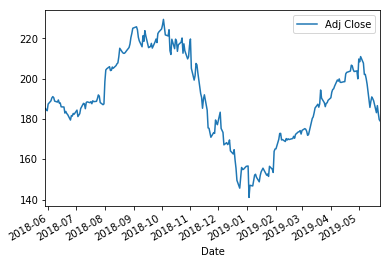

In [9]:
AAPL_ds.plot()

In [10]:
aapl_arr = AAPL_ds.iloc[:,0].values

In [11]:
aapl_arr.shape

(250,)

In [12]:
aapl_arr[0]

185.08267211914062

In [13]:
# divide the data into small batches and use them to train
def next_batch(batch_size,num_steps):
    x_batch = np.zeros((batch_size,num_steps))
    y_batch = np.zeros((batch_size,num_steps))
    
    for i in range(batch_size):
        stindex = np.random.randint(0,250-num_steps-1)
        #print(stindex)
        endindex = stindex + num_steps
        x_batch[i] = aapl_arr[stindex: stindex + num_steps]
        y_batch[i] = aapl_arr[stindex+1: stindex+num_steps+1]
    return x_batch, y_batch


In [14]:
x_batch, y_batch  = next_batch(10,20)

In [15]:
x_batch.shape, y_batch.shape

((10, 20), (10, 20))

In [16]:
x_batch[1]

array([155.56118774, 149.51054382, 145.64208984, 155.8984375 ,
       154.88668823, 154.96603394, 156.46383667, 156.6423645 ,
       141.03964233, 147.06051636, 146.73318481, 149.53038025,
       152.06967163, 152.55570984, 151.05792236, 148.78643799,
       151.83161926, 153.68649292, 154.5990448 , 155.55128479])

In [17]:
y_batch[1]

array([149.51054382, 145.64208984, 155.8984375 , 154.88668823,
       154.96603394, 156.46383667, 156.6423645 , 141.03964233,
       147.06051636, 146.73318481, 149.53038025, 152.06967163,
       152.55570984, 151.05792236, 148.78643799, 151.83161926,
       153.68649292, 154.5990448 , 155.55128479, 152.05975342])

In [18]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

#### Deep Learning using Tensorflow
Find the share price 1 day ahead

In [19]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [20]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [21]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [22]:
learning_rate = 0.001
# MSE
loss = tf.reduce_mean(tf.square(outputs - y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [23]:
# save the trained model so that it can be used later
saver = tf.train.Saver()
n_iterations = 1000
batch_size = 15

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        X_batch = X_batch.reshape(batch_size,n_steps,1)
        y_batch = y_batch.reshape(batch_size,n_steps,1)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_stock_series_model") # not shown in the content

0 	MSE: 24710.732
100 	MSE: 486.79703
200 	MSE: 75.29875
300 	MSE: 15.820937
400 	MSE: 9.170578
500 	MSE: 11.560244
600 	MSE: 12.486691
700 	MSE: 15.302767
800 	MSE: 7.5965333
900 	MSE: 12.110623


In [36]:
# restore the saved model
# pass the input to the model and get the prediction
with tf.Session() as sess:
    saver.restore(sess, "./my_stock_series_model")

    X_new = aapl_arr[109:129]
    X_new = X_new.reshape(1,20,1)
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    y_true= aapl_arr[110:130]
    print(y_pred)

INFO:tensorflow:Restoring parameters from ./my_stock_series_model
[[[216.17616]
  [220.22455]
  [205.44664]
  [200.42313]
  [201.6217 ]
  [207.73602]
  [207.21136]
  [202.46335]
  [192.7265 ]
  [192.23311]
  [186.56606]
  [190.3251 ]
  [190.9124 ]
  [183.4447 ]
  [175.5949 ]
  [176.06241]
  [172.35393]
  [173.6399 ]
  [172.04276]
  [178.88307]]]


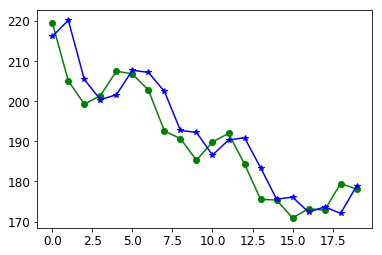

In [37]:
plt.plot(y_true, marker="o", color="green")
plt.plot(y_pred.ravel(), marker="*", color="blue")

In [26]:
#View First 5 records
AAPL_ds.head()

,Adj Close
Date,
2018-05-29,185.082672
2018-05-30,184.688675
2018-05-31,184.068115
2018-06-01,187.387604
2018-06-04,188.953751


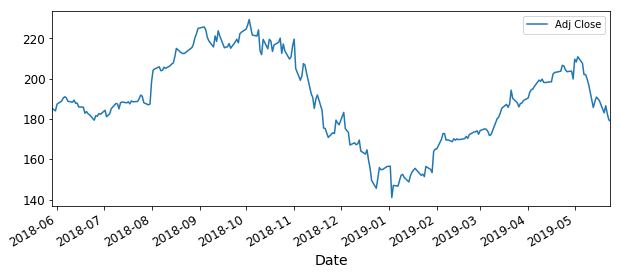

In [27]:
AAPL_ds.plot(legend=True, figsize=(10,4))

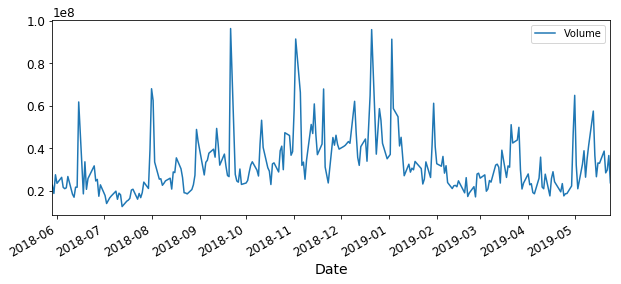

In [28]:
#view volume of stock traded every day
AAPL['Volume'].plot(legend=True, figsize=(10,4))

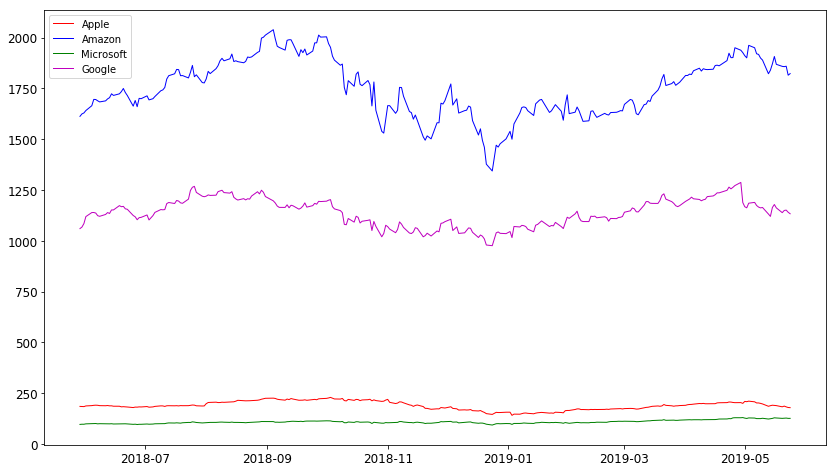

In [29]:
#plot all stock performances  on Adj close for entire year
plt.figure(figsize=(14,8))
plt.plot(AAPL['Adj Close'], 'r', label='Apple', linewidth=1)
plt.plot(AMZN['Adj Close'], 'b', label='Amazon', linewidth=1)
plt.plot(MSFT['Adj Close'], 'g', label='Microsoft', linewidth=1)
plt.plot(GOOG['Adj Close'], 'm', label='Google', linewidth=1)
plt.legend()
plt.show()

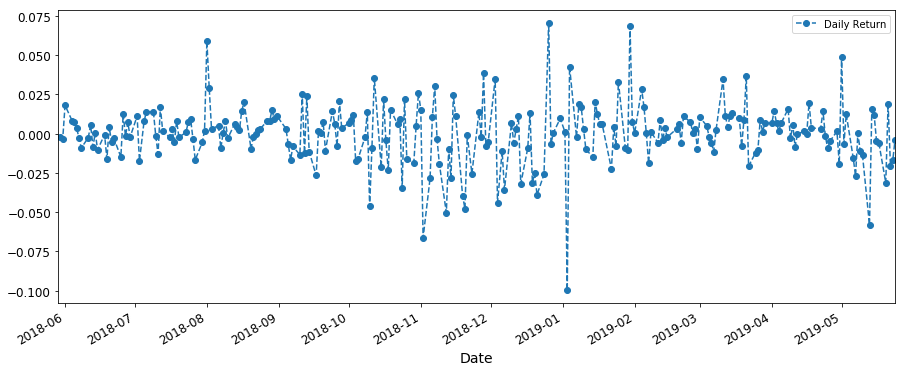

In [30]:
#computing pc chnage
AAPL['Daily Return'] = AAPL['Adj Close'].pct_change()
AAPL['Daily Return'].plot(figsize=(15,6), legend=True, linestyle='--', marker='o')

In [31]:
#Fetch closing prices
closing_price_stock = data.DataReader(['AAPL', 'AMZN', 'MSFT', 'GOOG'], 'yahoo', start , end)['Adj Close']

In [32]:
closing_price_stock.head()

Symbols,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-05-29,185.082672,1612.869995,1060.319946,96.443893
2018-05-30,184.688675,1624.890015,1067.800049,97.368874
2018-05-31,184.068115,1629.619995,1084.989990,97.260628
2018-06-01,187.387604,1641.540039,1119.500000,99.179474
2018-06-04,188.953751,1665.270020,1139.290039,100.045410


In [33]:
stock_returns = closing_price_stock.pct_change()

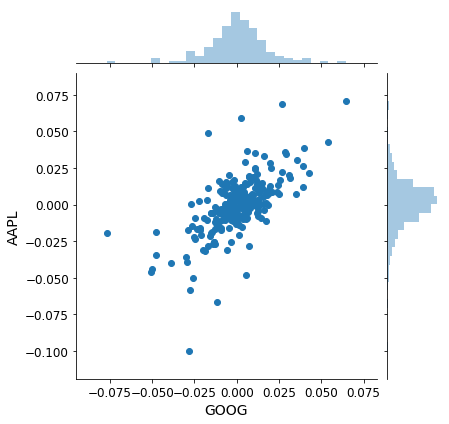

In [34]:
#compare daily returns of Google and Apple
sns.jointplot('GOOG', 'AAPL', stock_returns,kind='scatter')

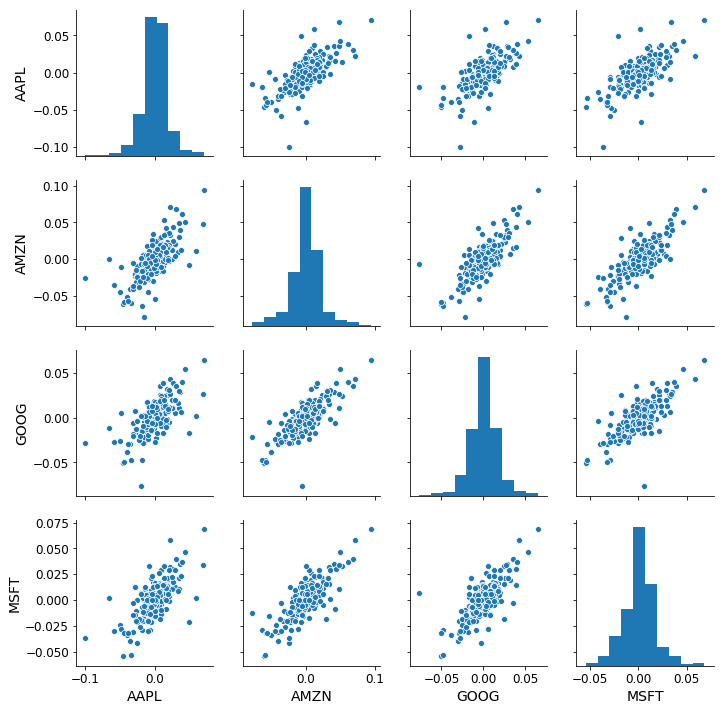

In [35]:
sns.pairplot(stock_returns.dropna())